In [1]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

#do not show warnings
import warnings
warnings.filterwarnings("ignore")

#import plotly for visualization
import plotly.offline as pyoff
import plotly.graph_objs as go

In [2]:
#import the csv
mntnc_data = pd.read_csv('/content/maintenance_history_data_with_null.csv')

In [51]:
mntnc_data.head()

,ASSET_ID,ASSET_TYPE,ASSET_CLASSIFICATION,MANUFACTURER_NAME,MODEL_NUMBER,ASSET_MAINTENANCE_DATE
0,1735,Early Smoke Detection,Mechanical,NaN,NaN,2020-05-20 11:05:00
1,2283,Makeup Air Unit,Mechanical,MUNTERS,NA2005/16,2018-08-01 09:01:00
2,1738,Early Smoke Detection,Mechanical,NaN,NaN,2020-05-20 11:05:00
3,1740,Early Smoke Detection,Mechanical,NaN,NaN,2020-05-20 11:05:00
4,1741,Early Smoke Detection,Mechanical,NaN,NaN,2020-05-20 11:05:00


In [3]:
#Drop null value rows
mntnc_data = mntnc_data.dropna(subset=['ASSET_MAINTENANCE_DATE'])

In [4]:
# import labelencoder
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

#convert the asset id to numeric
nonnumric_cols = ['ASSET_ID']
mntnc_data[nonnumric_cols] = mntnc_data[nonnumric_cols].apply(lambda col: le.fit_transform(col))

#convert date field from string to datetime
mntnc_data['ASSET_MAINTENANCE_DATE'] = pd.to_datetime(mntnc_data['ASSET_MAINTENANCE_DATE'])

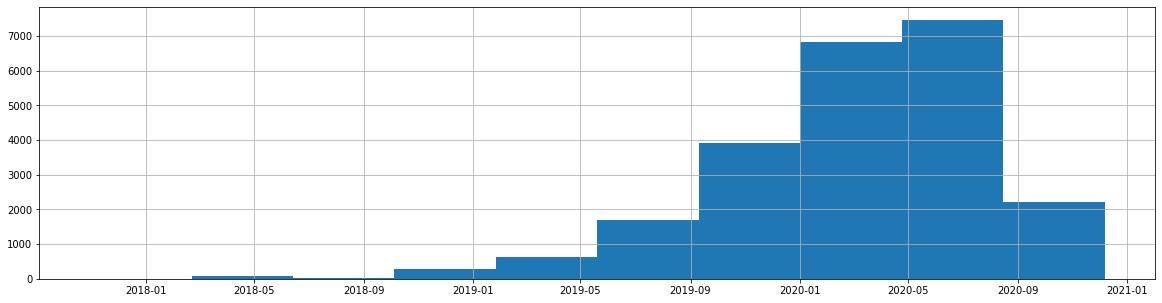

In [123]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()
mntnc_data.ASSET_MAINTENANCE_DATE.hist(ax=ax)

In [122]:
mntnc_data.ASSET_MAINTENANCE_DATE.describe()

count                   23150
unique                   1552
top       2020-03-22 12:03:00
freq                      702
first     2017-10-30 06:10:00
last      2020-12-06 12:06:00
Name: ASSET_MAINTENANCE_DATE, dtype: object

In [5]:
#@title Default title text
mntnc_2y = mntnc_data[(mntnc_data.ASSET_MAINTENANCE_DATE < pd.to_datetime('2020/5/30')) & (mntnc_data.ASSET_MAINTENANCE_DATE >= pd.to_datetime('2017/10/1'))].reset_index(drop=True)
mntnc_6M = mntnc_data[(mntnc_data.ASSET_MAINTENANCE_DATE >= pd.to_datetime('2020/5/30')) & (mntnc_data.ASSET_MAINTENANCE_DATE < pd.to_datetime('2020/12/30'))].reset_index(drop=True)


In [127]:
mntnc_6M.ASSET_MAINTENANCE_DATE.describe()

count                    6508
unique                    463
top       2020-06-20 01:06:00
freq                      122
first     2020-05-30 02:05:00
last      2020-12-06 12:06:00
Name: ASSET_MAINTENANCE_DATE, dtype: object

In [136]:
def df_histogram(col):
    fig = plt.figure(figsize = (20,5))
    ax = fig.gca()
    return col.hist(ax=ax)

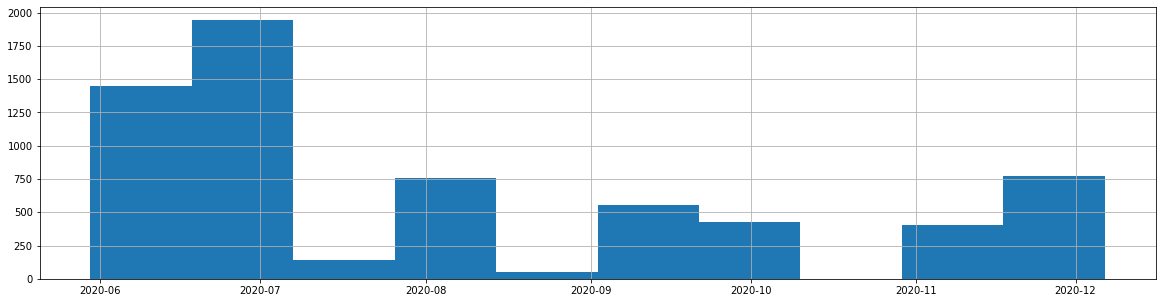

In [138]:
df_histogram(mntnc_6M.ASSET_MAINTENANCE_DATE)

In [6]:
assets_data = pd.DataFrame(mntnc_2y['ASSET_ID'].unique())
assets_data.columns = ['ASSET_ID']

#create a dataframe with asset id and recent maintenance data in mntnc_6M
tx_next_recent_maintenance = mntnc_6M.groupby('ASSET_ID').ASSET_MAINTENANCE_DATE.min().reset_index()
tx_next_recent_maintenance.columns = ['ASSET_ID','MinMaintenanceDate']

#create a dataframe with asset id and last maintenance date in mntnc_2y
tx_last_maintenance = mntnc_2y.groupby('ASSET_ID').ASSET_MAINTENANCE_DATE.max().reset_index()
tx_last_maintenance.columns = ['ASSET_ID','MaxMaintenanceDate']

#merge two dataframes
tx_maintenance_dates = pd.merge(tx_last_maintenance,tx_next_recent_maintenance,on='ASSET_ID',how='left')

#calculate the time difference in days:
tx_maintenance_dates['NextMaintenanceDay'] = (tx_maintenance_dates['MinMaintenanceDate'] - tx_maintenance_dates['MaxMaintenanceDate']).dt.days

#merge with assets_data 
assets_data = pd.merge(assets_data, tx_maintenance_dates[['ASSET_ID','NextMaintenanceDay']],on='ASSET_ID',how='left')

#fill NA values with 999
assets_data = assets_data.fillna(999)

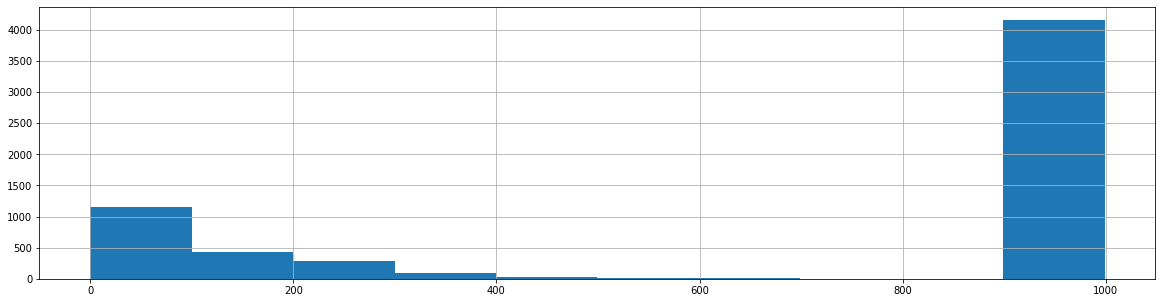

In [137]:
df_histogram(assets_data.NextMaintenanceDay)

In [139]:
assets_data.NextMaintenanceDay.describe()

count    6178.000000
mean      711.948365
std       417.323276
min         0.000000
25%       185.000000
50%       999.000000
75%       999.000000
max       999.000000
Name: NextMaintenanceDay, dtype: float64

**Recency - Frequency** calculation

Recently getting maintained 
Frequently getting maintained

In [7]:
#get max maintenance date for Recency and create a dataframe
tx_max_maintenance = mntnc_2y.groupby('ASSET_ID').ASSET_MAINTENANCE_DATE.max().reset_index()
tx_max_maintenance.columns = ['ASSET_ID','MaxMaintenanceDate']

#find the recency in days and add it to assets_data
tx_max_maintenance['Recency'] = (tx_max_maintenance['MaxMaintenanceDate'].max() - tx_max_maintenance['MaxMaintenanceDate']).dt.days
assets_data = pd.merge(assets_data, tx_max_maintenance[['ASSET_ID','Recency']], on='ASSET_ID')

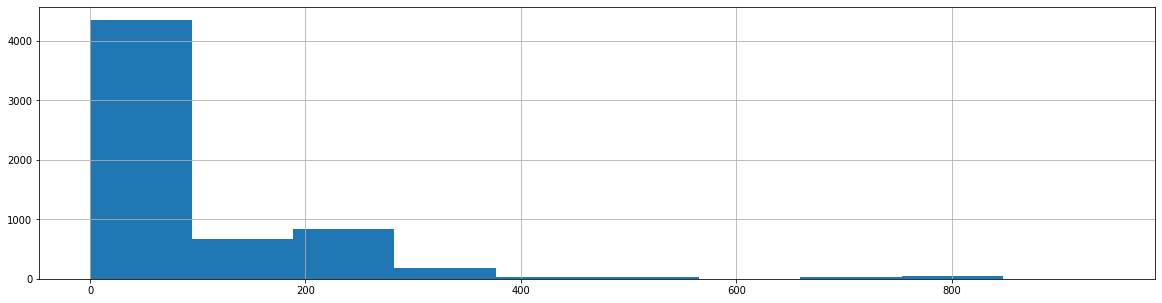

In [144]:
df_histogram(tx_max_maintenance.Recency)

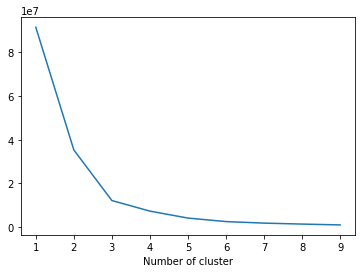

In [8]:
#plot the Recency 
from sklearn.cluster import KMeans


sse={}
tx_recency = assets_data[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [9]:
#clustering for Recency
kmeans = KMeans(n_clusters=4)
kmeans.fit(assets_data[['Recency']])
assets_data['RecencyCluster'] = kmeans.predict(assets_data[['Recency']])

In [146]:
assets_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2666.0,13.878470,14.398804,0.0,1.0,9.0,25.0,46.0
1,1081.0,221.164662,37.041102,154.0,193.0,217.0,260.0,300.0
2,159.0,381.031447,66.513387,303.0,328.0,355.0,446.0,509.0
3,85.0,773.941176,48.534561,654.0,749.0,793.0,793.0,942.0
4,2187.0,79.433928,22.999336,52.0,67.0,68.0,92.0,149.0


In [10]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#order recency clusters
assets_data = order_cluster('RecencyCluster', 'Recency',assets_data,False)

In [11]:
#print cluster characteristics
assets_data.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,108.0,716.657407,118.728085,480.0,654.0,749.0,793.0,942.0
1,1214.0,236.890445,57.980925,159.0,199.0,217.0,261.0,474.0
2,2190.0,79.536986,23.151481,52.0,67.0,68.0,92.0,155.0
3,2666.0,13.878470,14.398804,0.0,1.0,9.0,25.0,46.0


**Frequency** of Maintenance calculation

In [12]:
#get total maintenance for frequency scores
tx_matnce_frequency = mntnc_2y.groupby('ASSET_ID').ASSET_MAINTENANCE_DATE.count().reset_index()
tx_matnce_frequency.columns = ['ASSET_ID','Frequency']


In [170]:
tx_matnce_frequency.describe()

,ASSET_ID,Frequency
count,6178.000000,6178.000000
mean,4027.494335,2.693752
std,2055.255839,4.611832
min,0.000000,1.000000
25%,2287.250000,1.000000
50%,4135.500000,1.000000
75%,5754.750000,3.000000
max,7664.000000,70.000000


In [13]:
#add frequency column to assets_data
assets_data = pd.merge(assets_data, tx_matnce_frequency, on='ASSET_ID')

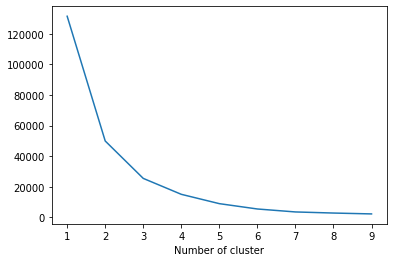

In [14]:
sse={}
tx_frequency = assets_data[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [15]:
#clustering for frequency
kmeans = KMeans(n_clusters=4)
kmeans.fit(assets_data[['Frequency']])
assets_data['FrequencyCluster'] = kmeans.predict(assets_data[['Frequency']])

#order frequency clusters and show the characteristics
assets_data = order_cluster('FrequencyCluster', 'Frequency',assets_data,True)

In [175]:
assets_data.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,5421.0,1.557093,0.884844,1.0,1.00,1.0,2.0,4.0
1,630.0,7.426984,2.599419,5.0,6.00,6.0,9.0,15.0
2,113.0,23.761062,6.979913,16.0,19.00,21.0,29.0,40.0
3,14.0,59.785714,6.350997,52.0,54.25,59.5,64.0,70.0


In [16]:
#building overall segmentation
assets_data['OverallScore'] = assets_data['RecencyCluster'] + assets_data['FrequencyCluster']

#assign segment names
assets_data['Segment'] = 'Low-Maintenance'
assets_data.loc[assets_data['OverallScore']>2,'Segment'] = 'Mid-Maintenance' 
assets_data.loc[assets_data['OverallScore']>4,'Segment'] = 'High-Maintenance'

In [50]:
assets_data.head()

,ASSET_ID,NextMaintenanceDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd
0,7267,132.0,3,3,4,0,3,Mid-Maintenance,3.0,4.0,39.0,13.000000,19.078784
1,7376,41.0,2,3,4,0,3,Mid-Maintenance,14.0,23.0,729.0,243.000000,400.977555
2,7299,8.0,0,3,4,0,3,Mid-Maintenance,16.0,23.0,548.0,182.666667,296.503513
3,1667,999.0,0,3,4,0,3,Mid-Maintenance,4.0,5.0,34.0,11.333333,15.373137
4,1669,999.0,0,3,4,0,3,Mid-Maintenance,4.0,5.0,34.0,11.333333,15.373137


In [17]:
#create a dataframe with Asset ID and Maintenance Date
mntnc_day_order = mntnc_2y[['ASSET_ID','ASSET_MAINTENANCE_DATE']]

#convert Maintenance Datetime to day
mntnc_day_order['MaintenanceDay'] = mntnc_2y['ASSET_MAINTENANCE_DATE'].dt.date
mntnc_day_order = mntnc_day_order.sort_values(['ASSET_ID','MaintenanceDay'])

#drop duplicates
mntnc_day_order = mntnc_day_order.drop_duplicates(subset=['ASSET_ID','MaintenanceDay'],keep='first')

#shifting last 3 Maintenance dates
mntnc_day_order['PrevMaintenanceDate'] = mntnc_day_order.groupby('ASSET_ID')['MaintenanceDay'].shift(1)
mntnc_day_order['T2MaintenanceDate'] = mntnc_day_order.groupby('ASSET_ID')['MaintenanceDay'].shift(2)
mntnc_day_order['T3MaintenanceDate'] = mntnc_day_order.groupby('ASSET_ID')['MaintenanceDay'].shift(3)
mntnc_day_order['DayDiff'] = (mntnc_day_order['MaintenanceDay'] - mntnc_day_order['PrevMaintenanceDate']).dt.days
mntnc_day_order['DayDiff2'] = (mntnc_day_order['MaintenanceDay'] - mntnc_day_order['T2MaintenanceDate']).dt.days
mntnc_day_order['DayDiff3'] = (mntnc_day_order['MaintenanceDay'] - mntnc_day_order['T3MaintenanceDate']).dt.days


mntnc_day_diff = mntnc_day_order.groupby('ASSET_ID').agg({'DayDiff': ['mean','std']}).reset_index()
mntnc_day_diff.columns = ['ASSET_ID', 'DayDiffMean','DayDiffStd']

In [18]:
mntnc_day_order_last = mntnc_day_order.drop_duplicates(subset=['ASSET_ID'],keep='last')

mntnc_day_order_last = mntnc_day_order_last.dropna()
mntnc_day_order_last = pd.merge(mntnc_day_order_last, mntnc_day_diff, on='ASSET_ID')

assets_data = pd.merge(assets_data, mntnc_day_order_last[['ASSET_ID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='ASSET_ID')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83386b3b38>,
      dtype=object)

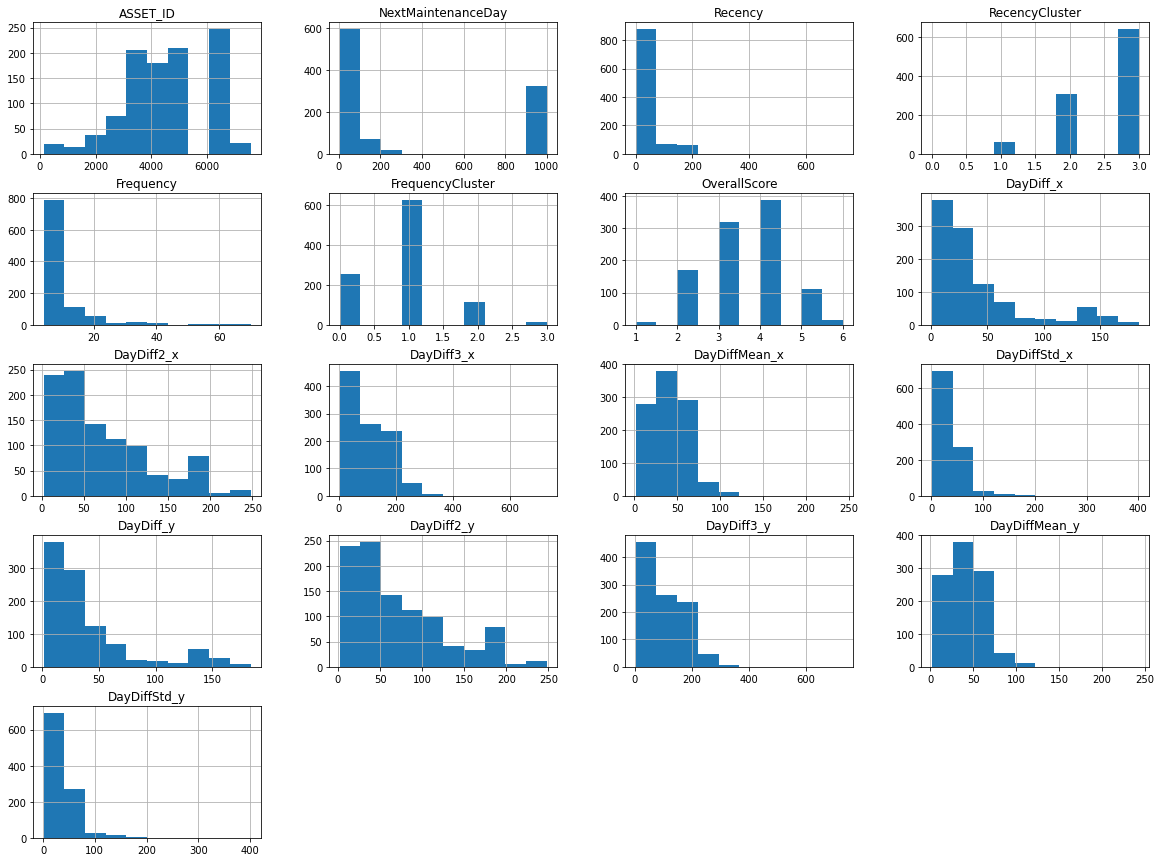

In [188]:
fig = plt.figure(figsize = (20,15))
ax = fig.gca()
assets_data.hist(ax=ax)

In [20]:
assets_data.columns

Index(['ASSET_ID', 'NextMaintenanceDay', 'Recency', 'RecencyCluster',
       'Frequency', 'FrequencyCluster', 'OverallScore', 'Segment', 'DayDiff',
       'DayDiff2', 'DayDiff3', 'DayDiffMean', 'DayDiffStd'],
      dtype='object')

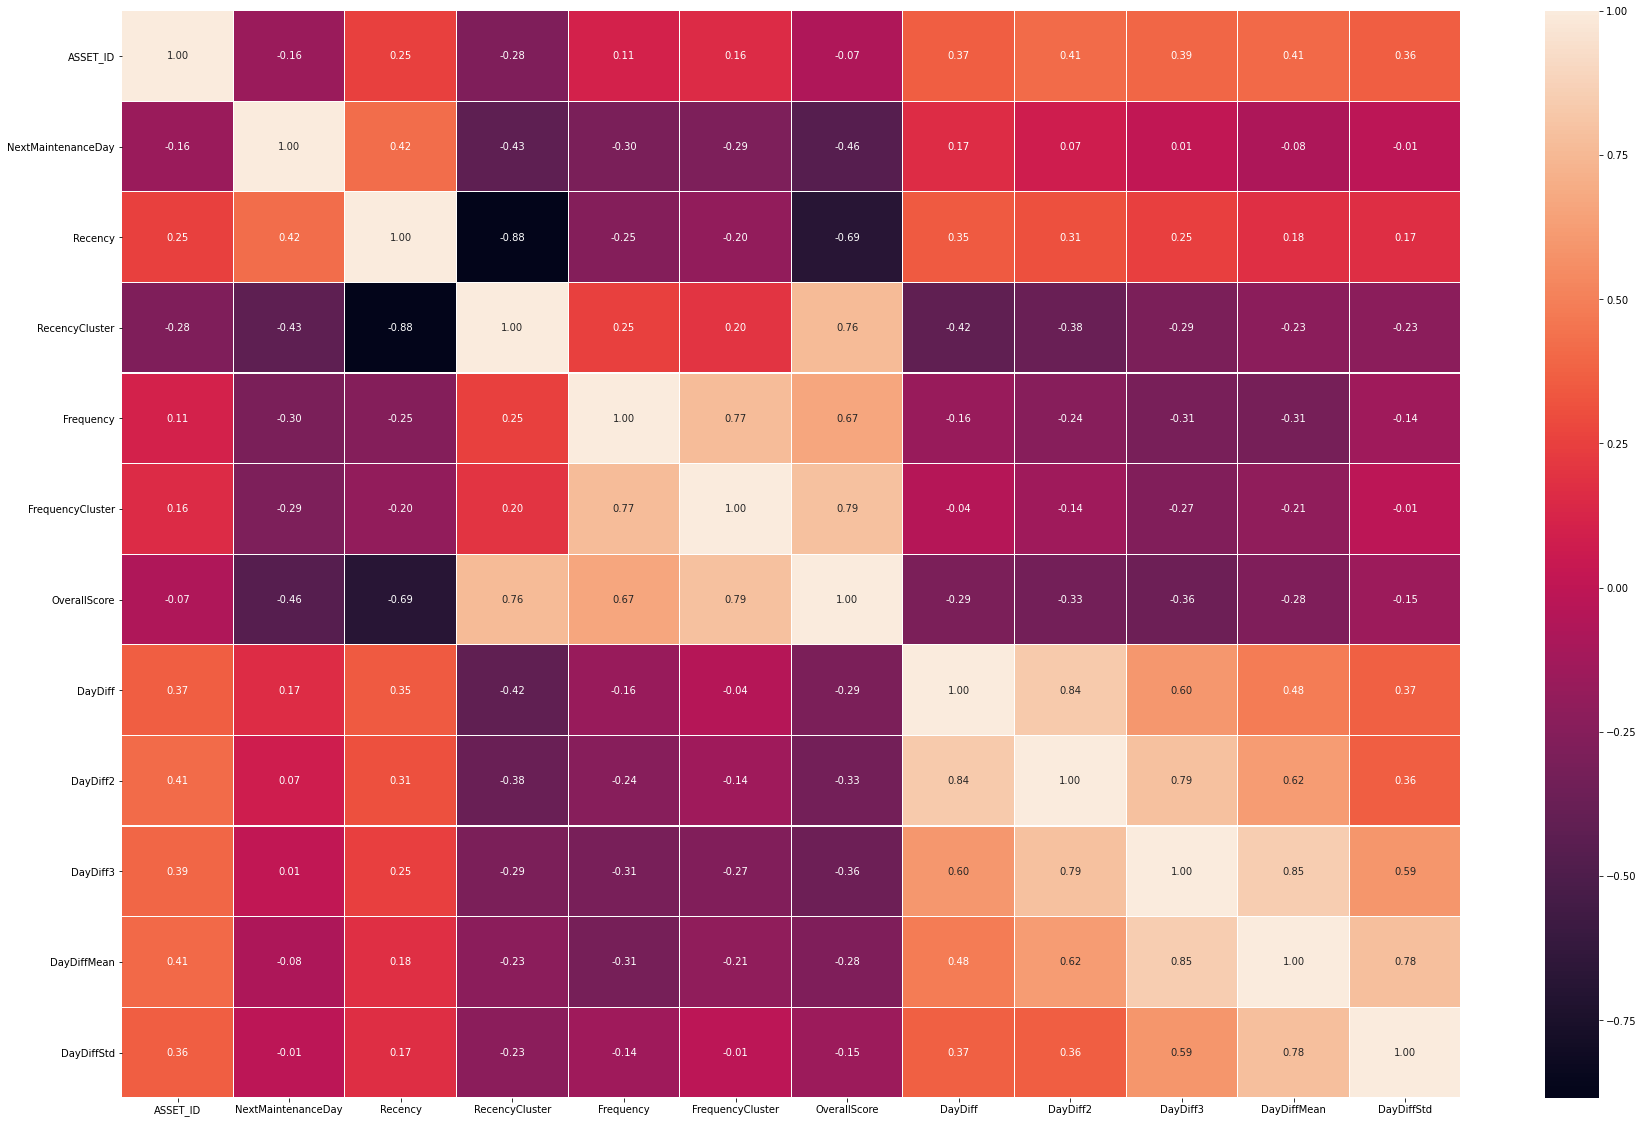

In [21]:
corr = assets_data[['ASSET_ID', 'NextMaintenanceDay', 'Recency', 'RecencyCluster',
       'Frequency', 'FrequencyCluster', 'OverallScore', 'Segment', 'DayDiff',
       'DayDiff2', 'DayDiff3', 'DayDiffMean', 'DayDiffStd']].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [58]:
#add the categorical feature columns
assets_data_cat_with_feature = pd.merge(assets_data, mntnc_data[['ASSET_ID', 'ASSET_TYPE', 'ASSET_CLASSIFICATION', 'MANUFACTURER_NAME', 'MODEL_NUMBER']], on='ASSET_ID')
#drop duplicate after join
assets_data_cat_with_feature = assets_data_cat_with_feature.drop_duplicates()
#https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd


In [52]:
assets_data_cat_with_feature.head()

,ASSET_ID,NextMaintenanceDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,ASSET_TYPE,ASSET_CLASSIFICATION,MANUFACTURER_NAME,MODEL_NUMBER
0,7267,132.0,3,3,4,0,3,Mid-Maintenance,3.0,4.0,39.0,13.000000,19.078784,Chiller Air Cooled,Mechanical,TRANE,RTAC-2504-UR04-UAFN-L1WY-1TDC-
5,7376,41.0,2,3,4,0,3,Mid-Maintenance,14.0,23.0,729.0,243.000000,400.977555,UPS,Electrical,EMERSON,10B14637G1C
10,7299,8.0,0,3,4,0,3,Mid-Maintenance,16.0,23.0,548.0,182.666667,296.503513,Generator,Electrical,CUMMINS,X07G306597
17,1667,999.0,0,3,4,0,3,Mid-Maintenance,4.0,5.0,34.0,11.333333,15.373137,CRAC,Mechanical,EMERSON,P2080UC
21,1669,999.0,0,3,4,0,3,Mid-Maintenance,4.0,5.0,34.0,11.333333,15.373137,CRAC,Mechanical,EMERSON,P3200DC


In [59]:
assets_data_cat_with_feature = assets_data_cat_with_feature.fillna('UNKNOWN')

In [49]:
assets_data_cat_with_feature.shape

(1011, 17)

In [60]:
#create assets_data_class as a copy of assets_data_cat_with_feature before applying get_dummies
assets_data_class = assets_data_cat_with_feature.copy()
assets_data_class = pd.get_dummies(assets_data_class)


*   0–30: Maintenance that will occour in 0–30 days — Class name: 3
*   30–90: Maintenance that will occour in 30–90 days — Class name: 2
*   90–150: Maintenance that will occour in 90–150 days — Class name: 1
*   ≥ 150: Maintenance that will occour in more than 150 days —Class name: 0

In [40]:
#class assign
assets_data_class['NextMaintenanceDayRange'] = 3
assets_data_class.loc[assets_data_class.NextMaintenanceDay>30,'NextMaintenanceDayRange'] = 2
assets_data_class.loc[assets_data_class.NextMaintenanceDay>90,'NextMaintenanceDayRange'] = 1
assets_data_class.loc[assets_data_class.NextMaintenanceDay>150,'NextMaintenanceDayRange'] = 0

**Multi-Classification Model**

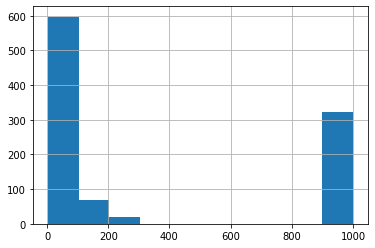

In [64]:
assets_data_class.NextMaintenanceDay.hist()

In [69]:
assets_data_class.head()

,ASSET_ID,NextMaintenanceDay,Recency,RecencyCluster,Frequency,FrequencyCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,DayDiffMean,DayDiffStd,Segment_High-Maintenance,Segment_Low-Maintenance,Segment_Mid-Maintenance,ASSET_TYPE_ATS,ASSET_TYPE_CRAC,ASSET_TYPE_CRAH,ASSET_TYPE_Centrifugal Pump,ASSET_TYPE_Chiller Air Cooled,ASSET_TYPE_Chiller Water Cooled,ASSET_TYPE_Cooling Plant,ASSET_TYPE_Cooling Tower,ASSET_TYPE_Early Smoke Detection,ASSET_TYPE_Fire Alarm,ASSET_TYPE_Fuel Distribution Pump,ASSET_TYPE_Fuel Polishing System,ASSET_TYPE_Fuel Storage Day Tank,ASSET_TYPE_Fuel Storage Tank,ASSET_TYPE_Fuel System Run Hour,ASSET_TYPE_Generator,ASSET_TYPE_Generator Paralleling Gear,ASSET_TYPE_Leak Detection,ASSET_TYPE_PDU,ASSET_TYPE_Rooftop Unit with Exhaust Fans,ASSET_TYPE_UPS,ASSET_TYPE_Utility,ASSET_CLASSIFICATION_Electrical,ASSET_CLASSIFICATION_Mechanical,MANUFACTURER_NAME_BAC,...,MODEL_NUMBER_CUSTOM,MODEL_NUMBER_CVHG1100,MODEL_NUMBER_D31A,MODEL_NUMBER_DTSC 200,MODEL_NUMBER_DTSC-200,MODEL_NUMBER_FenwalNet 2000ML,MODEL_NUMBER_GG4195,MODEL_NUMBER_GTA-50,MODEL_NUMBER_HIPULSE 500 kva,MODEL_NUMBER_HL4195,MODEL_NUMBER_KTA50G8,MODEL_NUMBER_KTA50GS8,MODEL_NUMBER_L13D02055,MODEL_NUMBER_L13D02060,MODEL_NUMBER_L18UC1020D03010CX,MODEL_NUMBER_L20EC1000D03120PX05,MODEL_NUMBER_LPL1150,MODEL_NUMBER_LPL1150 LPL1150 LPL1150 LPL11,MODEL_NUMBER_LVSI804T1,MODEL_NUMBER_Liebert NXA 800,MODEL_NUMBER_Liebert NXL 800,MODEL_NUMBER_NSX100H,MODEL_NUMBER_P2080UC,MODEL_NUMBER_P3200DC,MODEL_NUMBER_PH081DC,MODEL_NUMBER_PH161DC,MODEL_NUMBER_PU4500,MODEL_NUMBER_QSK60-G6_2000_KW_13kV,MODEL_NUMBER_QSK60G4,MODEL_NUMBER_RTAC-2504-UR04-UAFN-L1WY-1TDC-,MODEL_NUMBER_S31213C-RMV,MODEL_NUMBER_SEB120.3EG07.F2ARMA.ES10PE.E10,MODEL_NUMBER_SR-5,MODEL_NUMBER_SR5,MODEL_NUMBER_TRANE / RTAC5004URONUAFNNITY2C,MODEL_NUMBER_U39MM991A0ARS44,MODEL_NUMBER_UNKNOWN,MODEL_NUMBER_UT-212-436,MODEL_NUMBER_VXI-360-4X,MODEL_NUMBER_X07G306597
0,7267,132.0,3,3,4,0,3,3.0,4.0,39.0,13.000000,19.078784,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,7376,41.0,2,3,4,0,3,14.0,23.0,729.0,243.000000,400.977555,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,7299,8.0,0,3,4,0,3,16.0,23.0,548.0,182.666667,296.503513,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
17,1667,999.0,0,3,4,0,3,4.0,5.0,34.0,11.333333,15.373137,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21,1669,999.0,0,3,4,0,3,4.0,5.0,34.0,11.333333,15.373137,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [41]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.metrics import classification_report,confusion_matrix

In [42]:
#train & test split
assets_data_class = assets_data_class.drop('NextMaintenanceDay',axis=1)
X, y = assets_data_class.drop('NextMaintenanceDayRange',axis=1), assets_data_class.NextMaintenanceDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=44)

In [46]:
y_test.shape

(203,)

In [29]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("XGB",xgb.XGBClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2, random_state=22)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, cv_result)

LR [0.7029703  0.58663366]
NB [0.42821782 0.51980198]
RF [0.84653465 0.83168317]
SVC [0.37871287 0.45792079]
Dtree [0.85148515 0.80940594]
XGB [0.87871287 0.81683168]
KNN [0.77970297 0.79455446]


In [30]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.88


In [31]:
y_pred = xgb_model.predict(X_test)

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        89
           1       0.89      0.47      0.62        17
           2       0.83      0.90      0.86        58
           3       0.86      0.97      0.92        39

    accuracy                           0.88       203
   macro avg       0.87      0.81      0.82       203
weighted avg       0.88      0.88      0.87       203



**Hyperparameter Tuning.**

In [33]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(), 
param_grid = param_test1, scoring='accuracy',n_jobs=-1,iid=False, cv=2)
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 7, 'min_child_weight': 1}, 0.8564356435643564)

In [34]:
xgb_model = xgb.XGBClassifier(max_depth=7, min_child_weight=1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 1.00
Accuracy of XGB classifier on test set: 0.91


In [35]:
y_pred = xgb_model.predict(X_test)

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        89
           1       0.89      0.47      0.62        17
           2       0.84      0.93      0.89        58
           3       0.90      0.97      0.94        39

    accuracy                           0.91       203
   macro avg       0.90      0.83      0.85       203
weighted avg       0.91      0.91      0.90       203

